## Option Data Analysis

In [3]:
import altair
import pandas as pd
import numpy as np 
import  pandas_datareader as pdr
from pandas_datareader.yahoo.options import Options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.4f}'.format
import scipy.stats as stats
import pymc3 as pm

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')

import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Functions

In [10]:
def options_(options_df):
    options_df['Spread'] = options_df['Ask'] - options_df['Bid']
    options_df['DateToday'] = dt.date.today()
    options_df['Expiry'] = pd.to_datetime(options_df.Expiry)
    options_df['DateToday'] = pd.to_datetime(options_df.DateToday)
    options_df['DaysToExpiration'] = (options_df['Expiry'] - options_df['DateToday']).dt.days
    options_df["Intrinsic_Value"] = options_df['Strike']-options_df['Underlying_Price']
    options_df=options_df.dropna()
    return options_df

def custom_describe(df, nidx=3, nfeats=20):
    ''' Concat transposed topN rows, numerical desc & dtypes '''

    print(df.shape)
    nrows = df.shape[0]
    
    rndidx = np.random.randint(0,len(df),nidx)
    dfdesc = df.describe().T

    for col in ['mean','std']:
        dfdesc[col] = dfdesc[col].apply(lambda x: np.round(x,2))
 
    dfout = pd.concat((df.iloc[rndidx].T, dfdesc, df.dtypes), axis=1, join='outer')
    dfout = dfout.loc[df.columns.values]
    dfout.rename(columns={0:'dtype'}, inplace=True)
    
    # add count nonNAN, min, max for string cols
    nan_sum = df.isnull().sum()
    dfout['count'] = nrows - nan_sum
    dfout['min'] = df.min().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['max'] = df.max().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['nunique'] = df.apply(pd.Series.nunique)
    dfout['nan_count'] = nan_sum
    dfout['pct_nan'] = nan_sum / nrows
    
    return dfout.iloc[:nfeats, :]

### Data

In [5]:
options_df=pd.read_excel("../data/option_data/xlsx/sp500_options.xlsx")
options_df=options_df.drop("Unnamed: 0", axis=1)

In [6]:
options_df=options_(options_df)

In [7]:
options_df

,Strike,Expiry,Type,Last,Bid,Ask,Chg,Vol,Open_Int,IV,Underlying_Price,Symbol,Spread,DateToday,DaysToExpiration,Intrinsic_Value
1,140.0000,2021-02-26,call,40.9000,33.0000,37.5000,0.0000,2.0000,0.0000,1.5488,176.1100,MMM,4.5000,2021-02-24,2.0000,-36.1100
2,145.0000,2021-02-26,call,35.9000,29.1000,33.1500,0.0000,2.0000,0.0000,0.6250,176.1100,MMM,4.0500,2021-02-24,2.0000,-31.1100
3,150.0000,2021-02-26,call,26.1000,25.2500,26.9000,0.0000,2.0000,2.0000,1.0156,176.1100,MMM,1.6500,2021-02-24,2.0000,-26.1100
4,152.5000,2021-02-26,call,24.9400,23.1500,24.1500,0.0000,2.0000,2.0000,0.5391,176.1100,MMM,1.0000,2021-02-24,2.0000,-23.6100
5,157.5000,2021-02-26,call,11.9500,17.4000,19.1000,0.0000,2.0000,0.0000,0.6826,176.1100,MMM,1.7000,2021-02-24,2.0000,-18.6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180296,155.0000,2023-01-20,put,20.9000,19.0000,22.6000,0.0000,1.0000,8.0000,0.2906,160.1000,ZTS,3.6000,2021-02-24,695.0000,-5.1000
180297,160.0000,2023-01-20,put,23.2000,23.7000,28.3000,0.0000,1.0000,8.0000,0.3240,160.1000,ZTS,4.6000,2021-02-24,695.0000,-0.1000
180298,165.0000,2023-01-20,put,25.1800,24.6000,29.4000,0.0000,1.0000,1.0000,0.3022,160.1000,ZTS,4.8000,2021-02-24,695.0000,4.9000
180301,200.0000,2023-01-20,put,52.9500,47.5000,52.5000,0.0000,37.0000,11.0000,0.2870,160.1000,ZTS,5.0000,2021-02-24,695.0000,39.9000


### Bid-Ask Spread Analysis

In [46]:
sprd_by_dtm = (data.groupby(['Symbol', 'DaysToExpiration', 'Type'],
                            as_index=False)['Spread'].median()
               .groupby(['DaysToExpiration', 'Type'], as_index=False).median()
               .assign(bins = lambda x: pd.qcut(x.DaysToExpiration, 10, labels=False)))
sprd_by_dtm.head()

,DaysToExpiration,Type,Spread,bins
0,3.0000,call,0.2500,0
1,3.0000,put,0.1825,0
2,10.0000,call,0.3000,0
3,10.0000,put,0.2525,0
4,17.0000,call,0.4000,0


In [47]:
sprd_by_dtm['DaysToExpiration'] = sprd_by_dtm['DaysToExpiration'].astype(int)

In [48]:
sprd_by_dtm.head()

,DaysToExpiration,Type,Spread,bins
0,3,call,0.2500,0
1,3,put,0.1825,0
2,10,call,0.3000,0
3,10,put,0.2525,0
4,17,call,0.4000,0


In [49]:
def plot_spread_dtm(sprd_by_dtm):
    """given df plot scatter with regression line
    
    # Params
        df: pd.DataFrame()
    # Returns
        g: plotnine figure
    """  
    g = (pn.ggplot(sprd_by_dtm, pn.aes('DaysToExpiration', 'Spread', color='factor(bins)'))
         + pn.geom_point(pn.aes(shape='factor(bins)'))
         + pn.stat_smooth(method='lm')
         + pn.scale_y_continuous(breaks=range(0, int(sprd_by_dtm.Spread.max()+2)),
                                 labels=mzf.currency_format(), limits=(0, sprd_by_dtm.Spread.max()))
         + pn.scale_x_continuous(breaks=range(0, sprd_by_dtm.DaysToExpiration.max(), 50),
                                              limits=(0, sprd_by_dtm.DaysToExpiration.max()))
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),) 
         + pn.ylab('bid-ask spread')
         + pn.ggtitle('Option Spread by DTM'))
    return g

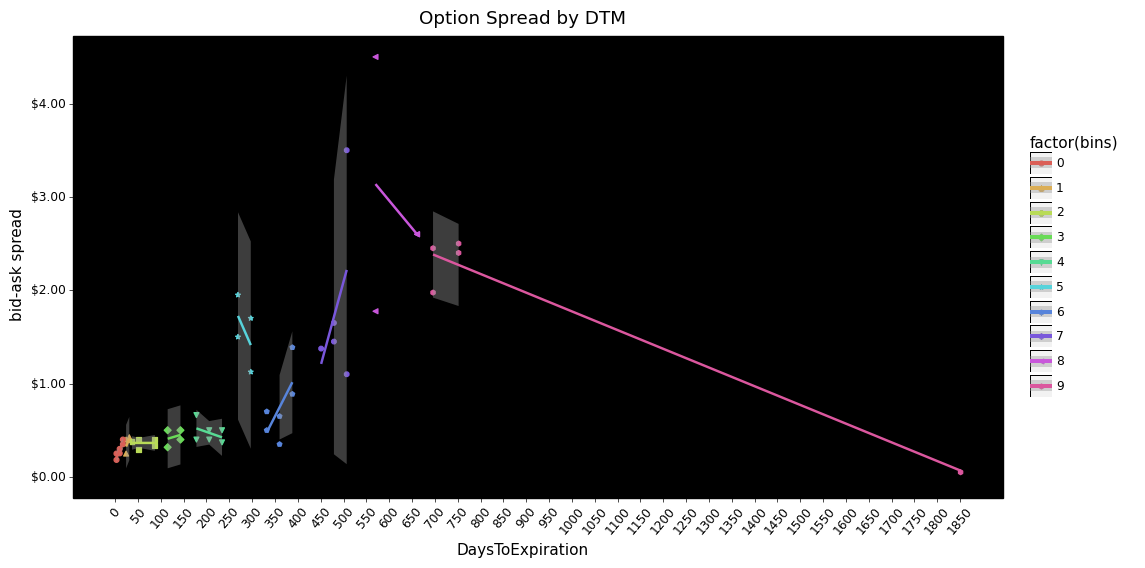

In [50]:
g = plot_spread_dtm(sprd_by_dtm)
g.save(filename='../plots/call-put option bid-ask spreads - daysToExpiration scatter plot.png')
g.draw();

### Selected Stock Options Only

In [51]:
median_sprd = data.groupby(['Symbol', 'DaysToExpiration', 'Type'],
                           as_index=False)['Spread'].median()

test_syms = ['AAPL', 'TSLA', 'AMD', 'NVDA', 'AMZN']
sel_med_sprd = median_sprd.query('Symbol in @test_syms').dropna(subset=['Spread'])
# to plot symbols have to cast to type str
sel_med_sprd.Symbol = sel_med_sprd.Symbol.astype(str)
print(sel_med_sprd.head())
print(sel_med_sprd.info())

   Symbol  DaysToExpiration  Type  Spread
52   AAPL            3.0000  call  0.0100
53   AAPL            3.0000   put  0.0300
54   AAPL           10.0000  call  0.0100
55   AAPL           10.0000   put  0.1000
56   AAPL           17.0000  call  0.0200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 52 to 6668
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Symbol            164 non-null    object 
 1   DaysToExpiration  164 non-null    float64
 2   Type              164 non-null    object 
 3   Spread            164 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.4+ KB
None


### How do bid-ask spreads vary with volume? 

In [52]:
grp_cols = ['Symbol', 'DaysToExpiration', 'Type']
agg_cols = ['Spread', 'Open_Int', 'Vol', 'IV', 'Intrinsic_Value']
median_sprd = data.groupby(grp_cols, as_index=False)[agg_cols].median()

test_syms = ['GOOGL', 'TSLA', 'AMD', 'NVDA', 'AMZN']
sel_med_sprd = (median_sprd.query('Symbol in @test_syms')
                .dropna(subset=['Spread', 'Open_Int']))

# to plot symbols have to cast to type str
sel_med_sprd.Symbol = sel_med_sprd.Symbol.astype(str)
sel_med_sprd.head()
print(sel_med_sprd.info())

,Symbol,DaysToExpiration,Type,Spread,Open_Int,Vol,IV,Intrinsic_Value
502,AMD,3.0000,call,0.0300,310.0000,72.0000,0.6289,9.7899
503,AMD,3.0000,put,0.1750,282.0000,51.0000,0.3052,6.5399
504,AMD,10.0000,call,0.0500,431.0000,100.0000,0.4727,6.2800
505,AMD,10.0000,put,0.1500,274.0000,56.0000,0.3718,4.2800
506,AMD,17.0000,call,0.1600,159.0000,46.0000,0.4810,6.2800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 502 to 6668
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Symbol            164 non-null    object 
 1   DaysToExpiration  164 non-null    float64
 2   Type              164 non-null    object 
 3   Spread            164 non-null    float64
 4   Open_Int          164 non-null    float64
 5   Vol               164 non-null    float64
 6   IV                164 non-null    float64
 7   Intrinsic_Value   164 non-null    float64
dtypes: float64(6), object(2)
memory usage: 11.5+ KB
None


In [53]:
def plot_log_points(df, x, y, color='factor(Symbol)', size='Open_Int'):
    g = (pn.ggplot(df, pn.aes(x, y, color=color))
         + pn.geom_point(pn.aes(size=size))
         + pn.scale_x_log10(breaks=[0,0.5,1,10,100,250,500,750,1_000])
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50))
         + pn.scale_y_continuous(breaks=range(0, int(df.Spread.max()+2)),
                                 labels=mzf.currency_format(), limits=(0, df.Spread.max()))
         + pn.ylab('bid-ask spread'))
    return g

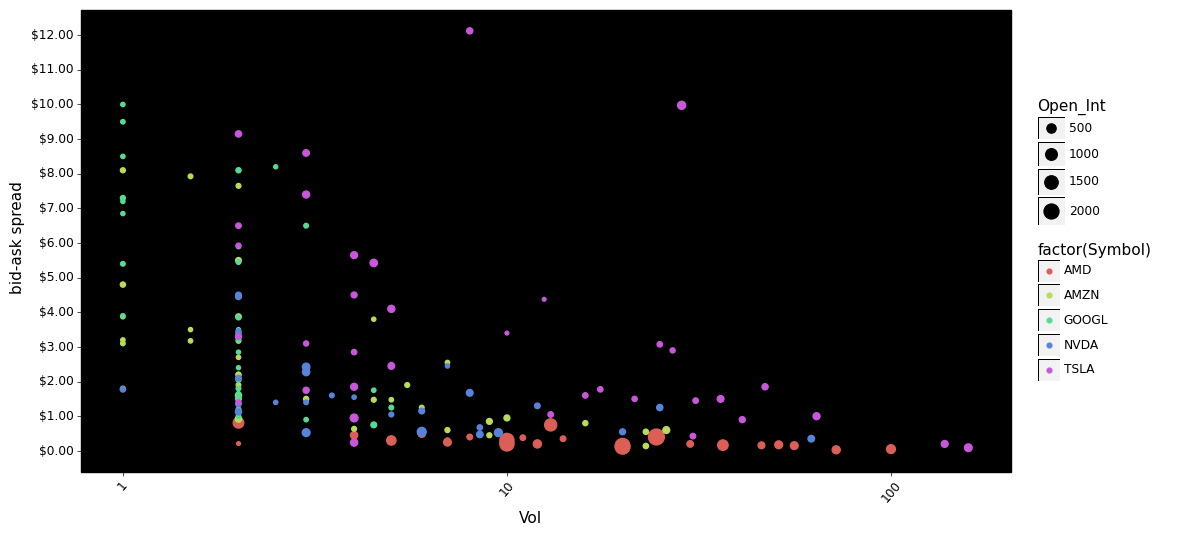

In [54]:
df = sel_med_sprd.copy()

# example with both call and puts
g = plot_log_points(df, x='Vol', y='Spread')
g.save(filename='../plots/call-put option bid-ask spreads - volume scatter plot.png')
g.draw();


### How do bid-ask spreads vary with volatility?

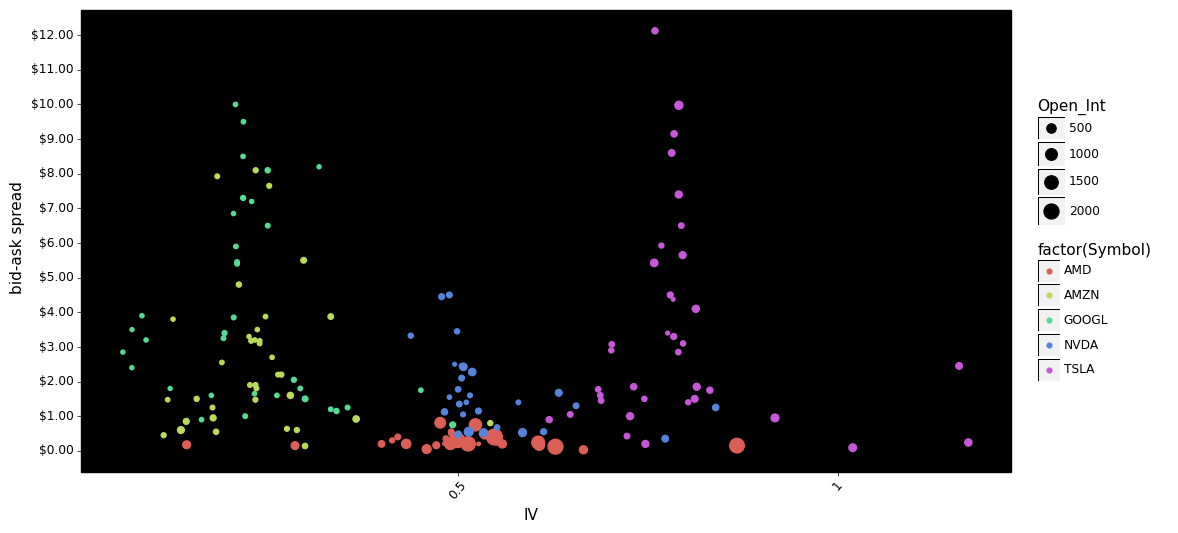

In [55]:
# example with both call and puts

g = plot_log_points(df, 'IV', 'Spread')
g.save(filename='../plots/call-put option bid-ask spreads - volatility scatter plot.png')
g.draw();
